In [ ]:
!pip install transformers

In [ ]:
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Load your train and test datasets
train = pd.read_csv('/local_path/eng_dep_covdtb_trains.csv')
test = pd.read_csv('/local_path/eng_dep_covdtb_test_results.csv')
test = test.drop('ChatGPT discourse relation', axis=1)

print(train.shape)
print(test.shape)

df = pd.concat([train, test], ignore_index=True)
print(df.shape)

(2399, 3)
(2585, 3)
(4984, 3)


In [ ]:
# exclude all the rows that have elaboration as class
print(len(df[df['Real discourse relation'] == 'elaboration']))
df = df[df['Real discourse relation'] != 'elaboration']
print(len(df))

2503
2481


In [ ]:
label_encoder = LabelEncoder()
df['Real discourse relation encoded'] = label_encoder.fit_transform(df['Real discourse relation'])

relations = df['Real discourse relation'].unique()

print(df.shape)

train_data = df[:int(len(df)*0.8)] 
test_data = df[int(len(df)*0.8):]  
print(df.head(1))

num_classes = len(label_encoder.classes_)
print(num_classes)

(2481, 4)
          EDU_1                                              EDU_2  \
0  Background :  EU Decision 1082/2013 / EU on serious cross - ...   

  Real discourse relation  Real discourse relation encoded  
0    textual-organization                               10  
11


In [ ]:
df.head()

,EDU_1,EDU_2,Real discourse relation,Real discourse relation encoded
0,Background :,EU Decision 1082/2013 / EU on serious cross - ...,textual-organization,10
1,EU Decision 1082/2013 / EU on serious cross - ...,this qualitative case study has investigated s...,background,1
3,The Decision provides a context for the presen...,which aims to identify good practices and lessons,enablement,5
5,Methods :,this qualitative case study has investigated s...,textual-organization,10
6,"Based on a documentary review ,",this qualitative case study has investigated s...,manner-means,8


In [ ]:
# Define a custom dataset class
class SentencePairDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        first_sentence = str(self.data.iloc[index]['EDU_1'])
        second_sentence = str(self.data.iloc[index]['EDU_2'])
        relation_label = int(self.data.iloc[index]['Real discourse relation encoded'])

        # Tokenize the input sentences
        inputs = self.tokenizer(first_sentence, second_sentence, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': torch.tensor(relation_label, dtype=torch.long)
        }

# Initialize a BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create datasets and data loaders
train_dataset = SentencePairDataset(train_data, tokenizer)
test_dataset = SentencePairDataset(test_data, tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64)
print(train_dataloader)

# Initialize and fine-tune a BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)  # Assuming 3 relation classes (positive, negative, neutral)
optimizer = AdamW(model.parameters(), lr=1e-5)

# Fine-tune the model on the training data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

for epoch in range(3):  
    print(epoch)
    for batch in train_dataloader:
        print("no")
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

# Evaluate the model on the test data
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        print("yes")
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels']

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        predictions.extend(logits.argmax(dim=1).cpu().numpy())
        true_labels.extend(labels.numpy())

In [ ]:
test_data['BERT predicted relation'] = predictions

In [ ]:
test_data.head()

,EDU_1,EDU_2,Real discourse relation,Real discourse relation encoded,BERT predicted relation
3999,7 ) using technology,to communicate with patients and carers ;,enablement,5,5
4000,1 ) responding rapidly and flexibly ;,8) adopting standardised data collection systems,joint,7,7
4001,8) adopting standardised data collection systems,to inform operational changes,enablement,5,5
4002,to inform operational changes,and improve care .,joint,7,7
4003,This study aimed to synthesise evidence for th...,An evidence synthesis on the role and response...,findings,6,6


In [ ]:
from sklearn.metrics import accuracy_score

print("Accuracy score = " + str(accuracy_score(test_data['Real discourse relation encoded'], test_data['BERT predicted relation'])))

Accuracy score = 0.682092555331992


In [ ]:
test_data['BERT predicted relation'].unique()

array([ 5,  7,  6,  1,  2,  3,  8,  0, 10])

In [ ]:
decoded_predictions = label_encoder.inverse_transform(predictions)
decoded_true_labels = label_encoder.inverse_transform(true_labels)

accuracy_score(decoded_true_labels, decoded_predictions)

0.682092555331992

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

f1_score(decoded_true_labels, decoded_predictions, average='macro')

0.5512240660995054

In [ ]:
import numpy as np

np.unique(decoded_predictions)

array(['attribution', 'background', 'cause-result', 'comparison',
       'enablement', 'findings', 'joint', 'manner-means',
       'textual-organization'], dtype=object)

In [ ]:
test_data['BERT predicted relation decoded'] = decoded_predictions

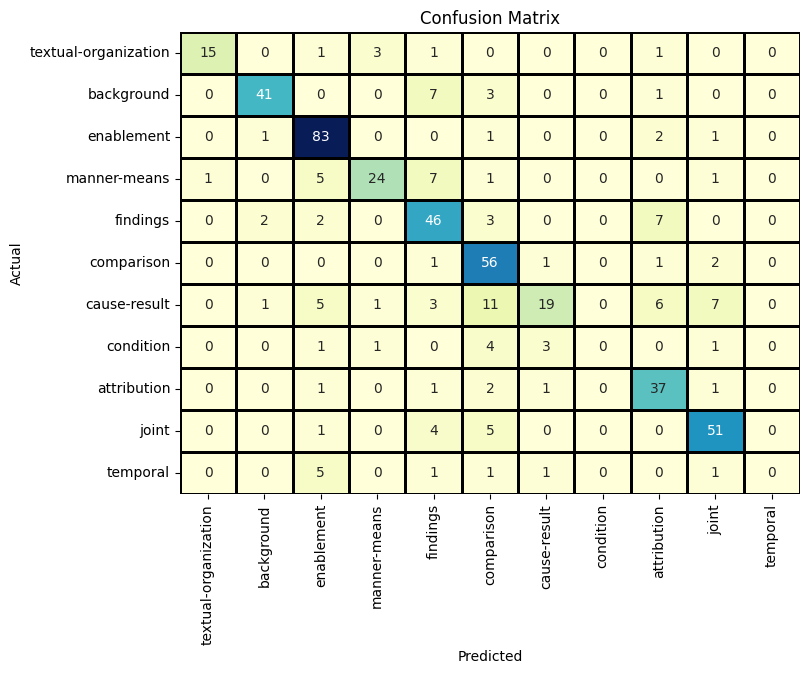

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(test_data["Real discourse relation"].astype(str), test_data["BERT predicted relation decoded"].astype(str), labels=relations)
confusion_df = pd.DataFrame(conf_matrix, index=relations, columns=relations)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="YlGnBu", linewidths=1, linecolor="black", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()